## Import
Use elements of the scientific python stack

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr

# Import a client
from dask.distributed import Client

# Import intake-esm
import intake

import util
from util import global_mean

import cf_xarray

## Setup a PBSCluster
Speed up processing with DASK with 8 threads

In [2]:
cluster = util.get_pbscluster(8)
# Setup your client
client = Client(cluster)
client

/glade/work/marsh/miniconda3/envs/default/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39229 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/marsh/proxy/39229/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/marsh/proxy/39229/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:36866,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/marsh/proxy/39229/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Open a catalog
Look for monthly reference height temperature

In [3]:
intake_catalog = "/glade/work/marsh/intake-esm-catalogs/WACCM6-TSMLT-GEO-SAI1.json"

cat = intake.open_esm_datastore(intake_catalog).search(variable=('TREFHT'), 
                                                       frequency=('month_1'))

print(cat.keys())

dict_keys(['atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005'])


In [4]:
dsets = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 8}, 'decode_times': False})
dsets.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'


dict_keys(['atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003'])

In [5]:
# a function that creates a contour plot of a (lat, time) reference height temperature field 
def plot_trefht(tref, case):
    
    print(case)
    fig = tref.plot.contourf(y='lat',
                             figsize=(15,6), 
                             levels=np.arange(240,310,2.5)
                         )
    fig.axes.set_ylabel('Latitude')
    fig.axes.set_xlabel('Year')
    plt.title('TREFHT')

    plt.show()
    return

In [6]:
# search for the SSP245 cases
hist_cases = [key for key in list(dsets) if "SSP245" in key]
print(len(hist_cases))

5


In [7]:
# functions that ensure the time field is centered between the time bounds values
# fixes an issue with the monthly CESM data have a time value that is the day following
# month (i.e., time = 2002-02-1 for the January mean)

def _get_tb_name_and_tb_dim(ds):
    """return the name of the time 'bounds' variable and its second dimension"""
    assert 'bounds' in ds.time.attrs, 'missing "bounds" attr on time'
    tb_name = ds.time.attrs['bounds']
    assert tb_name in ds, f'missing "{tb_name}"'
    tb_dim = ds[tb_name].dims[-1]
    return tb_name, tb_dim

def center_time(ds):
    """make time the center of the time bounds"""
    ds = ds.copy()
    attrs = ds.time.attrs
    encoding = ds.time.encoding
    tb_name, tb_dim = _get_tb_name_and_tb_dim(ds)

    ds['time'] = ds[tb_name].compute().mean(tb_dim).squeeze()
    attrs['note'] = f'time recomputed as {tb_name}.mean({tb_dim})'
    ds.time.attrs = attrs
    ds.time.encoding = encoding
    return ds

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001
atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005
atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002
atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004
atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003


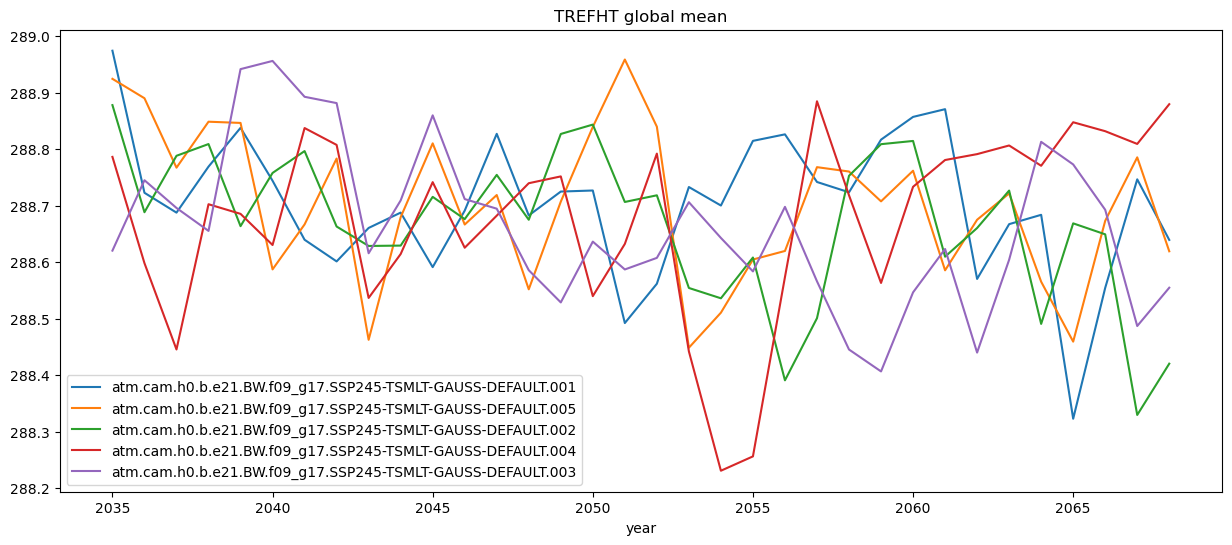

In [8]:
# plot the global mean annual mean TREFHT across all SSP245 cases

plt.figure(figsize=(15,6))
for case in hist_cases:
    print(case)
    ds = dsets[case]
    ds = xr.decode_cf(ds)
    ds = ds.sortby('time')

    ds = center_time(ds)
    tref = global_mean(ds['TREFHT'].sel(time=slice("2035-01", "2068-12")).groupby('time.year').mean())

    tref.plot(label=case)
plt.legend()
plt.title('TREFHT global mean')
plt.show()

In [9]:
ds['time'][0:5].values

array([cftime.DatetimeNoLeap(2035, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2035, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2035, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2035, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2035, 5, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [10]:
ds['time_bnds'][0:5].values

array([[cftime.datetime(2035, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
        cftime.datetime(2035, 2, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)],
       [cftime.datetime(2035, 2, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
        cftime.datetime(2035, 3, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)],
       [cftime.datetime(2035, 3, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
        cftime.datetime(2035, 4, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)],
       [cftime.datetime(2035, 4, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
        cftime.datetime(2035, 5, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)],
       [cftime.datetime(2035, 5, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
        cftime.datetime(2035, 6, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)]],
      dtype=object)

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001


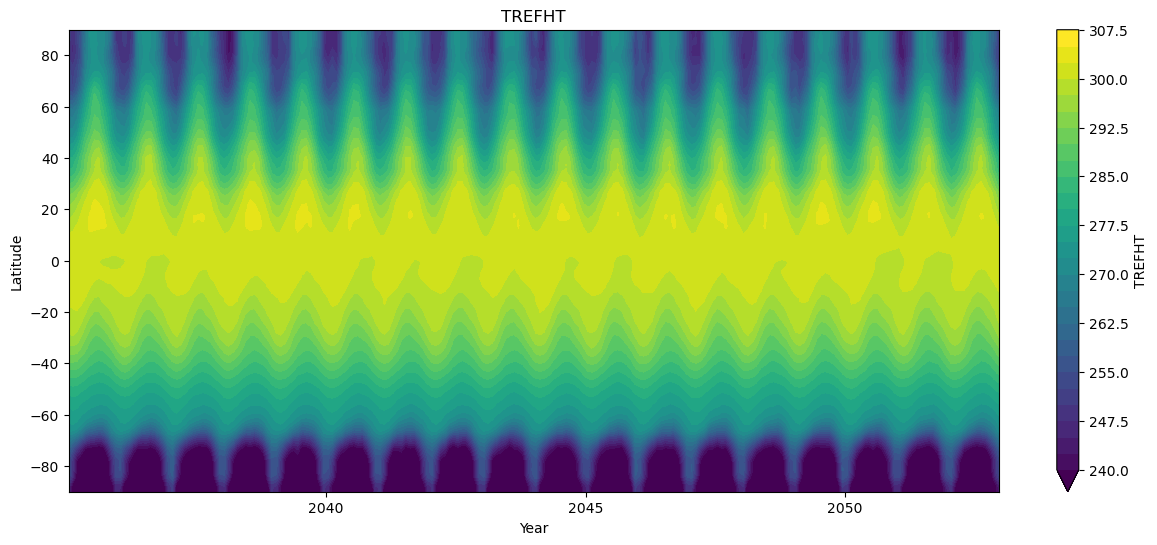

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001


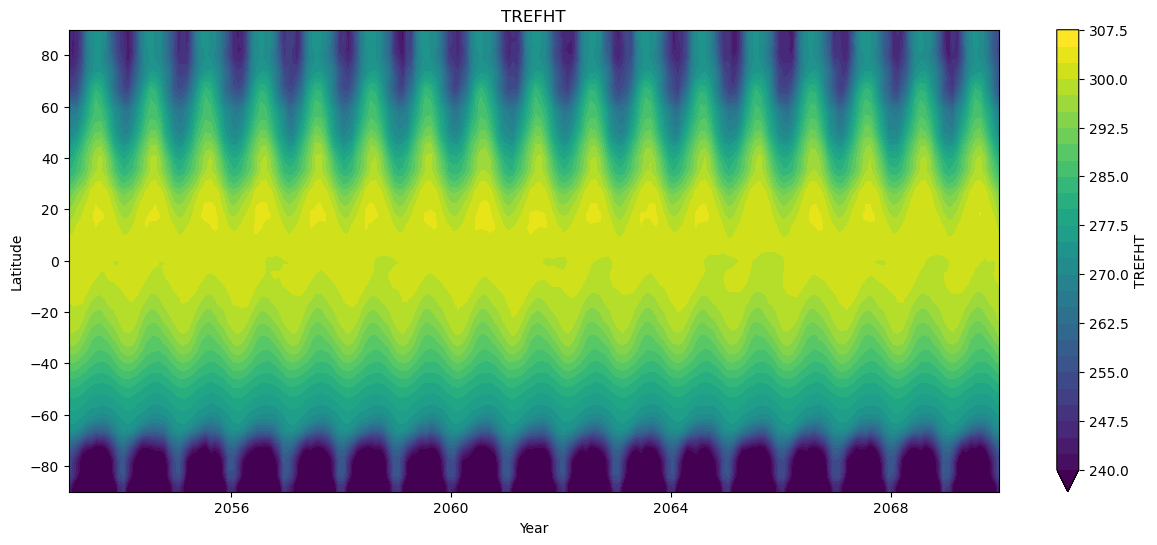

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005


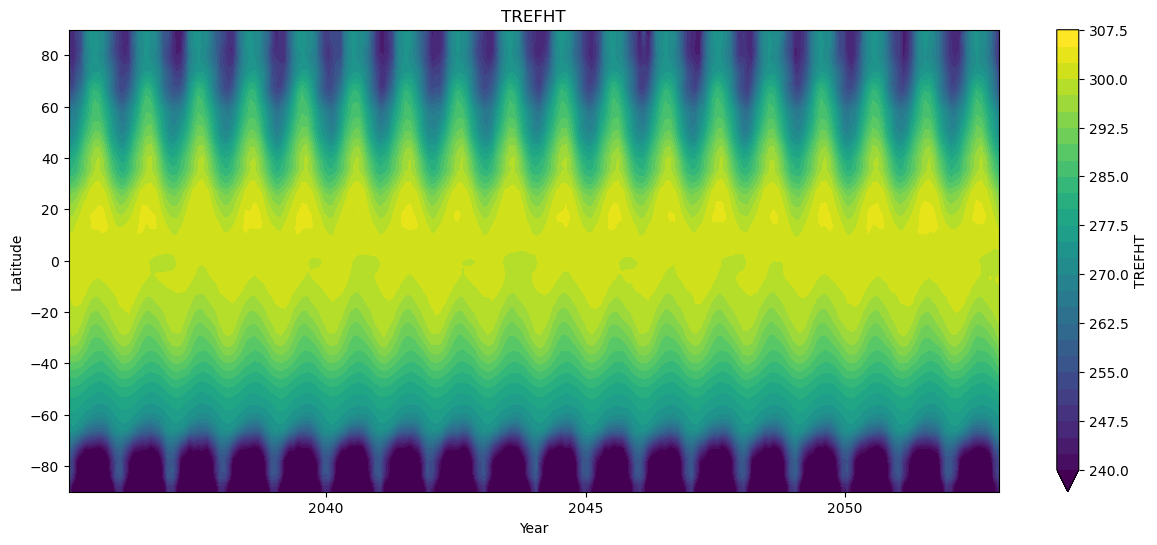

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005


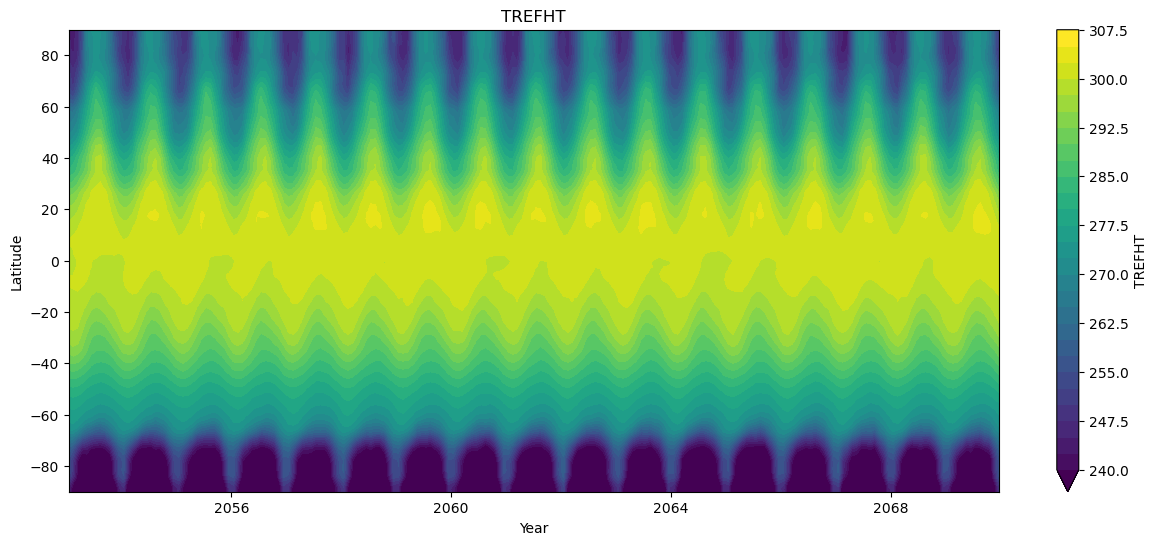

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002


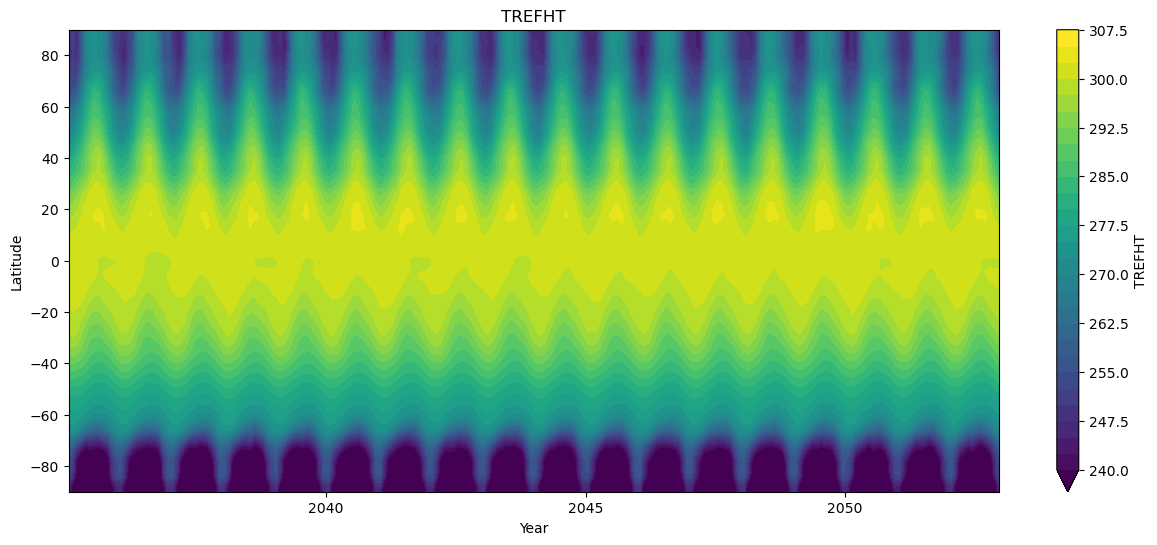

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002


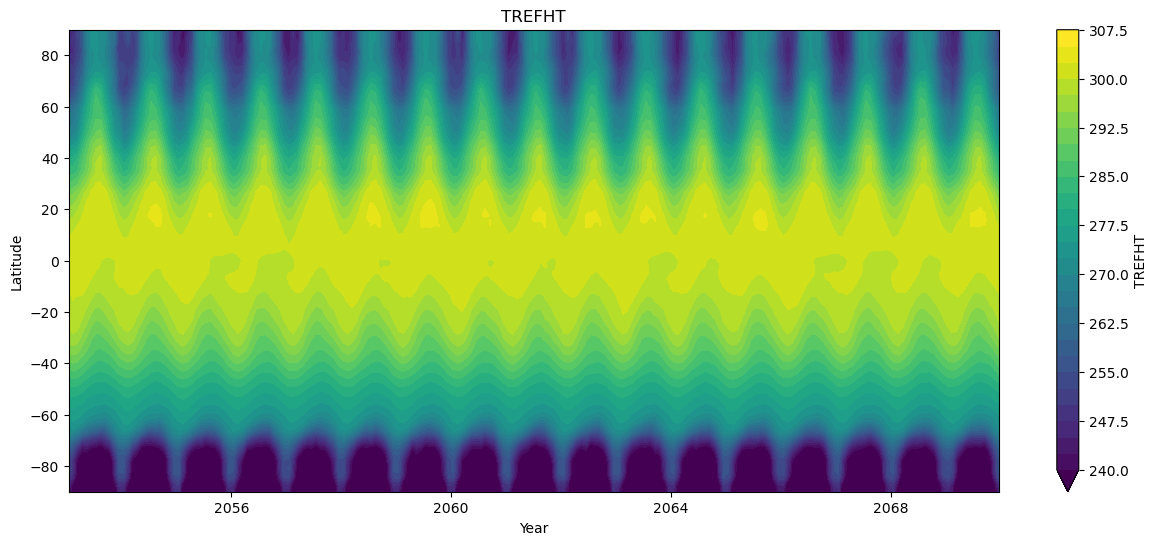

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004


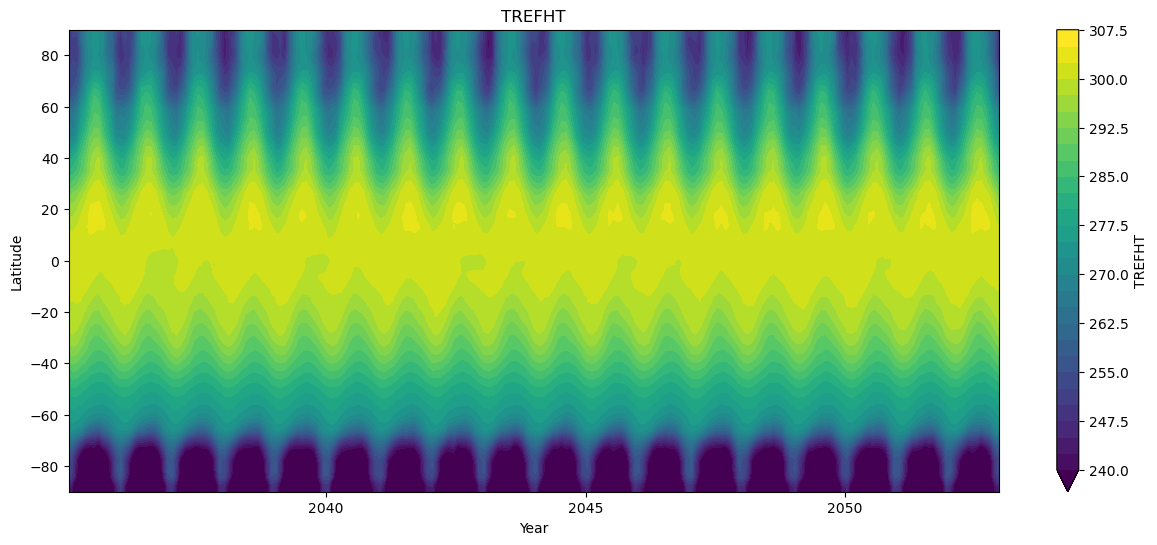

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004


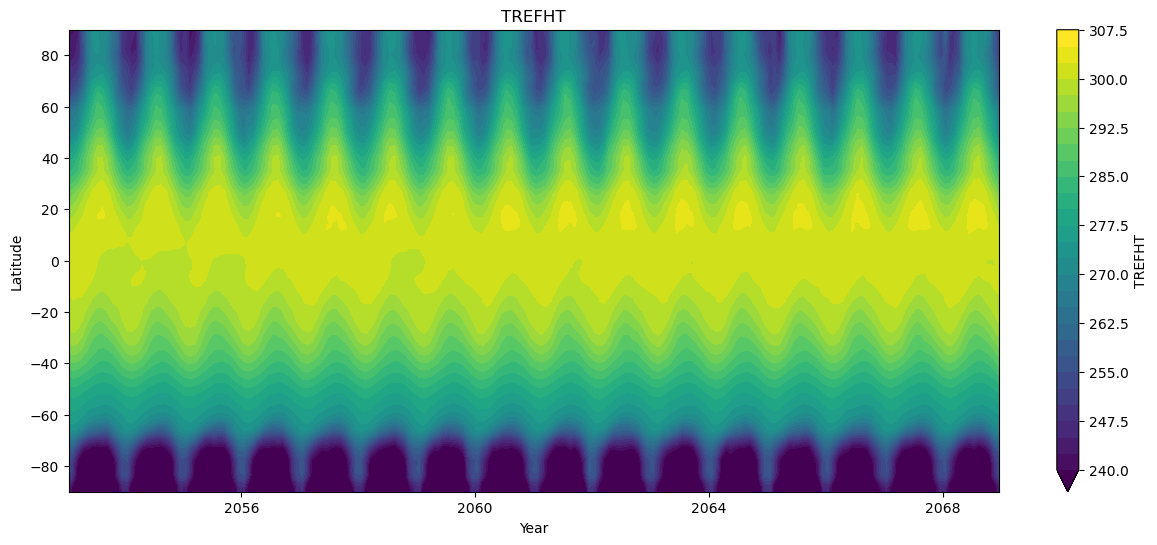

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003


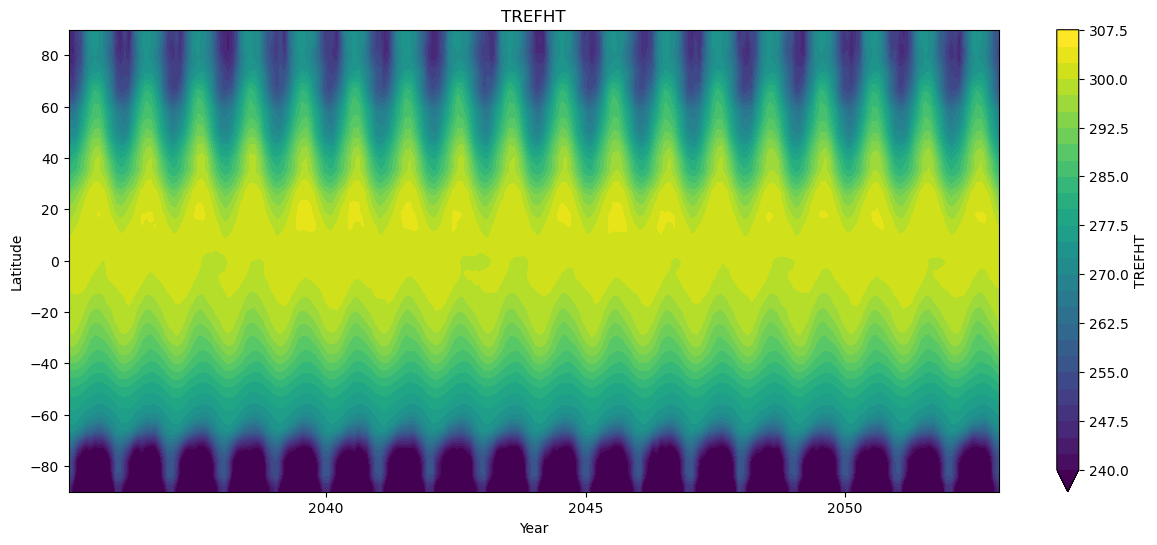

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003


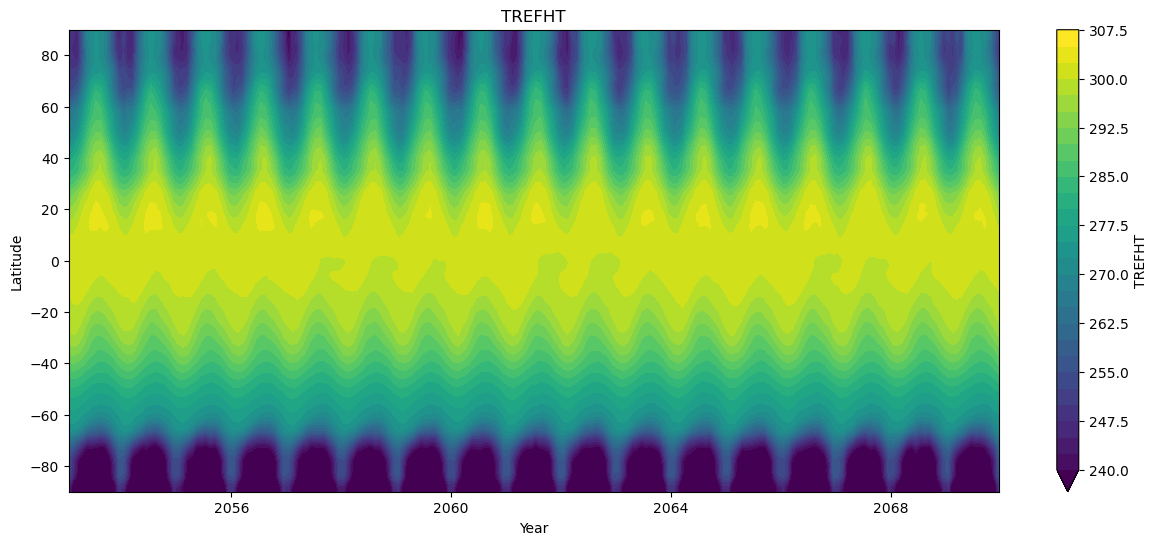

In [11]:
for case in hist_cases:
    # print(case)
    ds = dsets[case]
    ds = xr.decode_cf(ds)
    ds = ds.sortby('time')
    
    ds = center_time(ds)

    tref = ds['TREFHT'].sel(time=slice("2035-01", "2052-12")).mean(dim='lon')
    plot_trefht(tref, case)
    tref = ds['TREFHT'].sel(time=slice("2053-01", "2070-12")).mean(dim='lon')
    plot_trefht(tref, case)
